# Memoization

Memoization is a general technique for speeding up recursive algorithms. Specifically, in this technique if there is some function ```f``` taking in some inputs ```p```, we maintain a lookup table on the side indexed by possible such inputs. If ```f(p)``` has already been calculated in the past, we return ```f(p)``` from the lookup table. Otherwise, we compute it from scratch, insert it into the lookup table, then return it. We illustrate this technique below using an example.

We will show how we can use memoization to make significant savings in running time.

# Example1: Fun at Parties

You have a budget of $D$ dollars. You are given a list $L$ of parties $[ [c_0,f_0],\ldots, [c_{n-1},f_{n-1}]]$ where the $i^{th}$ party costs $c_i$ to attend and will give you $f_i$ units of fun.
What is the maximum amount of fun you can have with your budget?

We start by solving this with a simple recursive procedure. 
One way to think about this question is as follows:

* If there was only one party that has cost $c$ and yields fun $f$, then our decision is simple: if $D \geq c$ then we can attend the party and get $f$ units of fun, and otherwise we get zero units of fun.

* If there are two parties with costs/fun $(c_0,f_0)$ and $(c_1,f_1)$ then we might have a choice to make. It's often good in such cases to split a complicated choice to a sequence of simple choices. So let's start with the choice of whether or not to attend the first party. If we do attend it, then we'll get $f_0$ units of fun, and be left with a budget of $D-c_0$. If we don't then we get zero units of fun, and are left with $D$ dollars.

* Therefore if $\mathtt{maximum\_fun}(D,((c_0,f_0),\ldots,(c_n,f_n)))$ is the maximum amount of fun that we can have given a budget of $D$ and a the cost/funs $((c_0,f_0),\ldots, (c_n,f_n))$ then we have the following equation:

$\mathtt{maximum\_fun}(D,((c_0,d_0),\ldots,(c_n,f_n))) = \max \{ 0 + \mathtt{maximum\_fun}(D,((c_1,d_1),\ldots,(c_n,f_n))) , f_0 + \mathtt{maximum\_fun}(D-c_0,((c_1,d_1),\ldots,(c_n,f_n))) \}$.

Can you see why?

This now suggests a simple recursive algorithm for the '''maximum_fun''' function:

In [80]:
def maximum_fun(D,L):
    """returns the maximum amount of fun we can have with D dollars attending the parties listed in L, 
    where L is a tuple/list containing pairs (c,f) of cost/fun for every party."""
    
    step_pc() # ignore for now
    if not L:
        # if L is empty then we can't have any fun
        return 0
    fun_if_skip_first_party = maximum_fun(D,L[1:]) # the amount of fun we can have if we skip first party 
    if D<L[0][0]: # if we can't afford to attend the first party then we have no choices to make
        return fun_if_skip_first_party
    # otherwise we will check both options and see what's the maximum fun we can have
    return max(fun_if_skip_first_party, L[0][1]+maximum_fun(D-L[0][0],L[1:]))

Here are some examples:

* $\mathtt{maximum\_fun}(1,((2,10),))=0$: We can't afford to go to the party so get no fun (:
* $\mathtt{maximum\_fun}(2,((2,10),))=10$
* $\mathtt{maximum\_fun}(2,((2,5),(2,10)))=10$: We can afford both parties but the second one gives us more fun
* $\mathtt{maximum\_fun}(4,((1,6),(2,5),(3,6),(2,10)))=16$: The best combination is to go to the first  and fourth parties

In [81]:
maximum_fun(1,((2,10),))

0

In [82]:
maximum_fun(2,((2,10),))

10

In [83]:
maximum_fun(2,((2,5),(2,10)))

10

In [84]:
maximum_fun(4,((1,6),(2,5),(3,6),(2,10)))

16

So far so good, but what happens if we try a larger example?

In [85]:
n = 23
%timeit -n1 -r1 print "maximum_fun is ..",maximum_fun(n*n,[(i,i) for i in range(n)])

maximum_fun is .. 253
1 loop, best of 1: 7.97 s per loop


This starts to be a little slow. More generally, lets see how the time grows as a function of n

In [86]:
inputs = [((n*n),[(i,i) for i in range(n)]) for n in range(1,24)];

-----------------------
.......................0.489 micro-seconds per step
lengths, observations: 23 23 [[1]
 [2]
 [3]
 [4]
 [5]] [[ 1.5849625 ]
 [ 2.80735492]
 [ 3.9068906 ]
 [ 4.95419631]
 [ 5.97727992]]
Curve: $2\exp(1.010000n)$


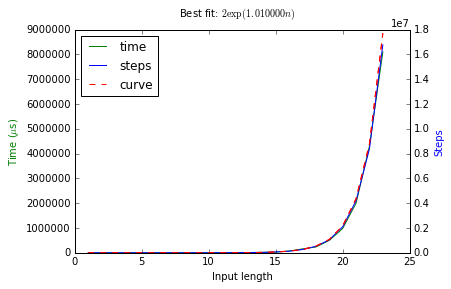

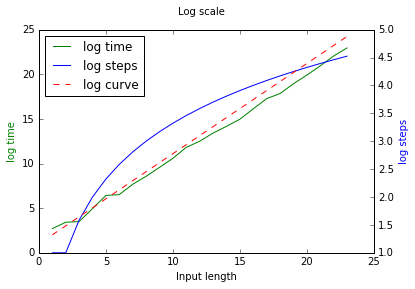

In [87]:
(outputs,curve,lengths,times,steps) = timer(maximum_fun,inputs,inlen = lambda i: len(i[1]) , doplot_logscale=False);

We can see that when we increase the input length by one we take about twice as much time. 
If we extrapolate from these data, we get that if we tried this for 40 parties (which might not be too much for some people), then the total amount of time it would take us to compute the sum would be about

In [120]:
t = curve(40)
"{0:,g} seconds".format(t)

'25,600 seconds'

Which equals 

In [89]:
"{:,} years".format(int(t/(365*24*60*60)))

'92,010 years'

_ouch!_

But do we really need to spend so much time? For example, when the input length was 

In [90]:
lengths[-1]

23

we made 

In [91]:
print "{:,} calls to the function".format(steps[-1])

16,777,215 calls to the function


But if we think about it, if our original input was a list $L$ of $n$ parties, and a budget $D$, every recursive call to the function '''maximize_fun''' was made with a pair $(D',L')$ such that $0 \leq D' \leq D$ and $L'$ is a postfix of $L$ (i.e., the last $i$ elements of $L$ for some $i\leq n$).

Since there are $D+1$ numbers between $0$ to $D$ and there are at most $n+1$ postfixes for an $n$ length list, we see that the total number of possible inputs we could have used is $(D+1)\times (n+1)$. 
But note that in our case this was

In [92]:
"{:,} possible inputs".format((inputs[-1][0]+1)*(len(inputs[-1][1])+1))

'12,720 possible inputs'

So we made a huge number of _unnecessary_ calls to the function. 
If we could simply remember the result of these calls, rather than executing them again, then we could potentially save a lot of time. 
This is what we do next. 
For starters, we use a global array '''Mem''' that will record for every $D'$ and $i$, the result of the function on the input which is $D'$ and the last $i$ elements of $L$. 
Later, we will have a solution which does not involve global variables. 


In [93]:
mem = []

def init_mem(D,L):
    global mem
    mem = [[-1]*(len(L)+1) for i in range(D+1)]


In [94]:
def maximum_fun_recur(D,L):
    """returns the maximum amount of fun we can have with D dollars attending the parties listed in L, 
    where L is a tuple/list containing pairs (c,f) of cost/fun for every party."""
    global mem
    step_pc() 
    if not mem[D][len(L)]==-1:
        return mem[D][len(L)]
    if not L:
        # if L is empty then we can't have any fun
        mem[D][0]=0
        return 0
    fun_if_skip_first_party = maximum_fun_recur(D,L[1:]) # the amount of fun we can have if we skip first party 
    if D<L[0][0]: # if we can't afford to attend the first party then we have no choices to make
        mem[D][len(L)] = fun_if_skip_first_party
        return fun_if_skip_first_party
    # otherwise we will check both options and see what's the maximum fun we can have
    mem[D][len(L)] =  max(fun_if_skip_first_party, L[0][1]+maximum_fun_recur(D-L[0][0],L[1:]))
    return mem[D][len(L)]

def memoized_maximum_fun(D,L):
    init_mem(D,L)
    return maximum_fun_recur(D,L)

Lets see that we get the same answers:

In [95]:
memoized_maximum_fun(1,((2,10),))

0

In [96]:
memoized_maximum_fun(2,((2,10),))

10

In [97]:
memoized_maximum_fun(2,((2,5),(2,10)))

10

In [98]:
memoized_maximum_fun(4,((1,6),(2,5),(3,6),(2,10)))

16

Now let's see if we indeed get a speed saving:

In [99]:
inputs = [((n*n),[(i,i) for i in range(n)]) for n in range(1,100)];

---------------------------------------------------------------------------------------------------
...................................................................................................0.971 micro-seconds per step
lengths, observations: 99 99 [[1]
 [2]
 [3]
 [4]
 [5]] [[ 1.5849625 ]
 [ 2.32192809]
 [ 3.169925  ]
 [ 4.08746284]
 [ 4.95419631]]
fitting lengths, steps: 99 99 [1, 2, 3, 4, 5] [3, 5, 9, 17, 31]
Found coefficients: [ 0.32198634  0.          0.          0.          0.          0.        ]
Rounded coefs: [0.4, 0.0, 0.0, 0.0, 0.0, 0.0]
(array([0], dtype=int64),)
Curve: $0.4n^3$


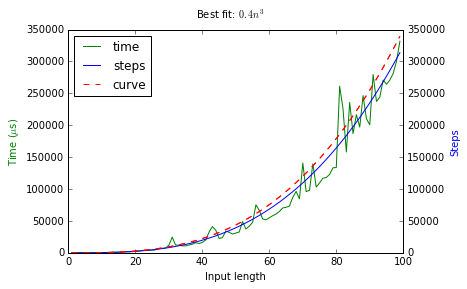

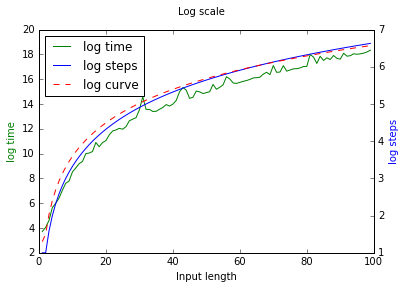

In [100]:
(outputs_mem,_1,_2,_3,_4) = timer(memoized_maximum_fun,inputs,inlen = lambda i: len(i[1]) ,doplot_logscale = False);

In [101]:
outputs == outputs_mem[:len(outputs)] # sanity check

True

In particular for $n=40$ this took us about $35$ milliseconds instead of $40,000$ years, not bad...

We typically try to avoid global variables, and so let's rewrite the program without them by adding an extra parameter to the recursion:

In [102]:
def maximum_fun_recur2(D,L,mem):
    """returns the maximum amount of fun we can have with D dollars attending the parties listed in L, 
    where L is a tuple/list containing pairs (c,f) of cost/fun for every party."""
    step_pc() 
    if not mem[D][len(L)]==-1:
        return mem[D][len(L)]
    if not L:
        # if L is empty then we can't have any fun
        mem[D][0]=0
        return 0
    fun_if_skip_first_party = maximum_fun_recur2(D,L[1:],mem) # the amount of fun we can have if we skip first party 
    if D<L[0][0]: # if we can't afford to attend the first party then we have no choices to make
        mem[D][len(L)] = fun_if_skip_first_party
        return fun_if_skip_first_party
    # otherwise we will check both options and see what's the maximum fun we can have
    mem[D][len(L)] =  max(fun_if_skip_first_party, L[0][1]+maximum_fun_recur2(D-L[0][0],L[1:],mem))
    return mem[D][len(L)]

def memoized_maximum_fun2(D,L):
    mem = [[-1]*(len(L)+1) for i in range(D+1)]
    return maximum_fun_recur2(D,L,mem)

Let's do some sanity check, and then see if it makes a performance difference

In [103]:
memoized_maximum_fun2(4,((1,6),(2,5),(3,6),(2,10)))

16

---------------------------------------------------------------------------------------------------
...................................................................................................0.926 micro-seconds per step
lengths, observations: 99 99 [[1]
 [2]
 [3]
 [4]
 [5]] [[ 1.5849625 ]
 [ 2.32192809]
 [ 3.169925  ]
 [ 4.08746284]
 [ 4.95419631]]
fitting lengths, steps: 99 99 [1, 2, 3, 4, 5] [3, 5, 9, 17, 31]
Found coefficients: [ 0.32198634  0.          0.          0.          0.          0.        ]
Rounded coefs: [0.4, 0.0, 0.0, 0.0, 0.0, 0.0]
(array([0], dtype=int64),)
Curve: $0.4n^3$


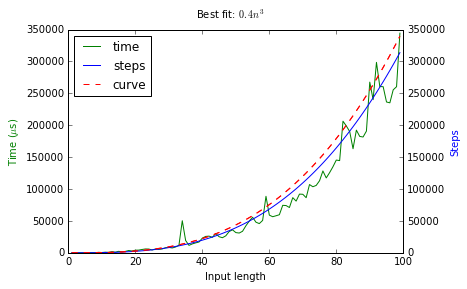

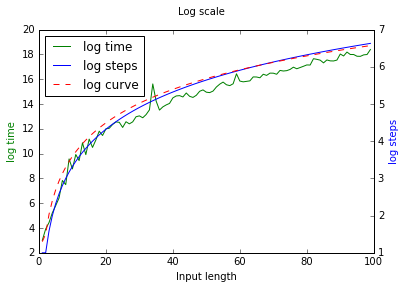

In [104]:
timer(memoized_maximum_fun2,inputs,inlen = lambda i: len(i[1]) , doplot_logscale= False);

### Exercise 1: Best parenthesis placement.

You are given an arithmetic expression with digits separated by `*` and `+`.  How can you parenthesize the expression so as to maximize its value?  For example, with the expression $1+2*3+4*5$ the best way of parenthesizing it is $(1+2)*((3+4)*5)$, giving $105$. For example, parenthesizing it as $1+((2*3)+(4*5))$ would only give $27$.

Suppose the length of the expression is $n$.  We will show how to
solve the task in time $\approx n^3$ using recursion and memoization.

First, a recursive solution:

If the expression is $s$ of length $n$, then we can split it in $(n-1)/2$ different ways to the form  $s_1\ op\ s_2$. If $\mathtt{max\_paren}(s_i)$ is the maximum value that we can obtain from parenthesizing the expression $s_i$, then $\mathtt{max\_paren}(s)$ would equal the maximum of $\mathtt{max\_paren}(s_1)\ op\ \mathtt{max\_paren}(s_2)$ over all these splits. This suggests the following code: 


In [1]:
def applyOp(op,x,y):
    if op=='+':
        return x+y
    elif op=='*':
        return x*y
    else:
        raise BaseException("Operators can be either * or +: you used "+str(op))

def max_paren(s):
    vals = []
    if len(s)==1:
        return int(s)
    for i in range(1,len(s),2): # go over positions 1,3,..,len(s)-1, which should be the operators:
        vals.append(applyOp(s[i],max_paren(s[:i]),max_paren(s[i+1:])))
    return max(vals)

In [2]:
max_paren("1+2*3+4*5")

105

Unfortunately this code can be quite slow even for expressions that are not too long.

In [13]:
max_paren("1+2*3+4*5*0+4*8+9*3*4+2+3+8*4")

1456560

Implement ```max_paren_fast``` below to use <b>memoization</b> in order to speed up ```max_paren```.

In [14]:
# returns the maximum value that can be obtained by parenthesizing s[a:b]
def max_paren_memoized(a, b, s, seen, mem):
    #write your code here
    pass

def max_paren_fast(s):
    seen = [[[False] for x in range(len(s)+1)] for y in range(len(s)+1)]
    mem = [[[0] for x in range(len(s)+1)] for y in range(len(s)+1)]
    return max_paren_memoized(0, len(s), s, seen, mem)

[[[False], [False]], [[False], [False]], [[False], [False]]]

### Exercise 2

Suppose you live in a country whose coin denominations are in the list ```L```. For example, in Ethiopia we would have ```L = [1,5,10,25,50,100]```, but other countries have different coin systems. Implement a function ```makeChange(n, L)``` which returns the minimum number of coins needed to make change for ```n``` cents using the coins in ```L```. For example, ```makeChange(14, [1,5,10,25,50,100])``` should return ```5```, since you can make change for ```14``` cents by giving one ```10```-cent piece and four ```1```-cent pieces, for a total of ```5``` coins (you could also give two ```5```-cent pieces and four ```1```-cent pieces, or ```14``` ```1```-cent pieces, but those options would each require more coins). If it is impossible to make change for ```n``` cents using ```L```, you should return ```-1```. For example, ```makeChange(3, [2, 5])``` should return ```-1``` since there is no way to make change for ```3``` cents using ```2```-cent and ```5```-cent pieces.

First implement ```makeChange``` using plain recursion. Then implement a faster version using memoization.

In [15]:
def makeChange(n, L):
    # write your code here
    pass

In [ ]:
print makeChange(14, [1,5,10,25,50,100])
# should print 5

print makeChange(3, [2,5])
# should print -1

print makeChange(8, [1,4,5])
# should print 2 since it is better to use two 4-cent pieces than one 5-cent pieces and three 1-cent pieces

### Exercise 3

Write a function ```lis(L)``` which takes as input a list of integers ```L``` and outputs the length of the longest increasing subsequence (lis) of ```L```. A subsequence of ```L``` is a sublist of ```L``` that does not have to be contiguous. For example, ```[1,5,9]``` is a subsequence of the list ```L = [1,2,3,4,5,6,7,8,9]``` since ```1,5,9``` appear in the list ```L``` in the same order (though just not in a row). ```9,5,1``` is not a subsequence of ```L``` since it does not appear in ```L``` in that order.

First implement ```lis``` using plain recursion, then implement a faster version using memoization.

In [ ]:
def lis(L):
    # write your code here
    pass

In [ ]:
print lis([1,2,3,4,5,6,7,9])
# should print 9, since the entire list is an increasing sequence

print lis([5,6,7,1,2,3,4])
# should print 4, since the LIS is 1,2,3,4

print lis([5,1,6,2,7,3,4])
# should print 4, since the LIS is still 1,2,3,4